##### Goal: predict price_differences from data like days, times or pools #####

In [1]:
import os
import pdb
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from scripts.databasing import build_table
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder

In [2]:
# Get our data
file_loc = "../data/to_db.log"
df = build_table(file_loc)

In [3]:
# Understanding our data
df.shape

(31389, 10)

In [4]:
# Understanding our data II
df.head()

,date,time,level,dex,pool_asset,cex,cex_asset,price_diff,dex_price,cex_price
0,2023-02-08,"12:52:33,630",WARNING,THORChain,AVAX,Binance,AVAX,99.951600,19.964328558,19.945000000
1,2023-02-08,"12:52:36,950",WARNING,THORChain,BCH,Binance,BCH,99.917400,132.168226076,131.950000000
2,2023-02-08,"12:52:39,648",WARNING,THORChain,AVA,Binance,AVA,99.797700,0.715598593,0.718500000
3,2023-02-08,"12:52:41,081",WARNING,THORChain,BNB,Binance,BNB,99.900200,326.801585434,326.150000000
4,2023-02-08,"12:52:47,237",WARNING,THORChain,ETH,Binance,ETH,99.969300,1645.006361279,1643.995000000


In [5]:
# Understanding our data III
df.dtypes

date          object
time          object
level         object
dex           object
pool_asset    object
cex           object
cex_asset     object
price_diff    object
dex_price     object
cex_price     object
dtype: object

In [6]:
# Checking for Nans or non-conviniently called columns
df.isna() 

# La tabla no tienen Nans o columnas con nombres raros... se puede considerar que el trabajo 
# de limpieza se hizo previemente, desde el código que generó la información...

,date,time,level,dex,pool_asset,cex,cex_asset,price_diff,dex_price,cex_price
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
31384,False,False,False,False,False,False,False,False,False,False
31385,False,False,False,False,False,False,False,False,False,False
31386,False,False,False,False,False,False,False,False,False,False
31387,False,False,False,False,False,False,False,False,False,False


In [7]:
#Creando una nueva columna util
df["time"] = df["time"].astype(str).str[:-4]
df["unix_datetime"] = df["date"] + " " + df["time"]
df["unix_datetime"]

0        2023-02-08 12:52:33
1        2023-02-08 12:52:36
2        2023-02-08 12:52:39
3        2023-02-08 12:52:41
4        2023-02-08 12:52:47
                ...         
31384    2023-02-10 16:19:50
31385    2023-02-10 16:19:53
31386    2023-02-10 16:19:58
31387    2023-02-10 16:19:59
31388    2023-02-10 16:20:00
Name: unix_datetime, Length: 31389, dtype: object

In [8]:
# Dando el formato adecuado a cada columna

df["price_diff"] = df["price_diff"].astype(float)
df["dex_price"] = df["dex_price"].astype(float)
df["cex_price"] = df["cex_price"].astype(float)
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df["time"] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df["unix_datetime"] = pd.to_datetime(df['unix_datetime']).map(pd.Timestamp.timestamp)

In [9]:
# Limpiar columnas que no sirven
df = df.drop(["level", "dex", "cex"], axis=1)
df.head()

,date,time,pool_asset,cex_asset,price_diff,dex_price,cex_price,unix_datetime
0,2023-02-08,12:52:33,AVAX,AVAX,99.9516,19.964329,19.9450,1.675861e+09
1,2023-02-08,12:52:36,BCH,BCH,99.9174,132.168226,131.9500,1.675861e+09
2,2023-02-08,12:52:39,AVA,AVA,99.7977,0.715599,0.7185,1.675861e+09
3,2023-02-08,12:52:41,BNB,BNB,99.9002,326.801585,326.1500,1.675861e+09
4,2023-02-08,12:52:47,ETH,ETH,99.9693,1645.006361,1643.9950,1.675861e+09


In [10]:
# No es necesario quitar outliers aunque si será bueno quitar diferencias demasiado chicas (ex. price_diff <.08%)

print("Dimensiones de la tabla og:", df.shape)
print("Diferencia mayor: ", df['price_diff'].min())
print("Diferencia menor: ", df['price_diff'].max())

lower_limit = np.percentile(df['price_diff'], 50)
df = df[(df['price_diff'] < lower_limit)]

print("Dimensiones de la tabla ahora:", df.shape)
print("Diferencia mayor: ", df['price_diff'].min())
print("Diferencia menor: ", df['price_diff'].max())


Dimensiones de la tabla og: (31389, 8)
Diferencia mayor:  97.2511
Diferencia menor:  100.0
Dimensiones de la tabla ahora: (15693, 8)
Diferencia mayor:  97.2511
Diferencia menor:  99.9169


In [11]:
# Info para graficar en Tableau
time_info = df[["date", "time"]]

# Numerical
numerical = df.select_dtypes("number")
y = numerical['price_diff']
numerical = numerical.drop("price_diff", axis=1)

# Categorical 
categorical = df[["pool_asset", "cex_asset"]]

/var/folders/vp/lnx3vw2x7s39s7tbl04ls9780000gn/T/ipykernel_94436/451461628.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical[numerical.columns[i]])


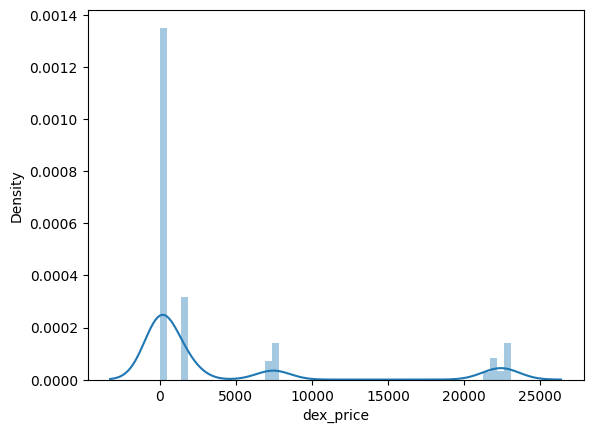

/var/folders/vp/lnx3vw2x7s39s7tbl04ls9780000gn/T/ipykernel_94436/451461628.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical[numerical.columns[i]])


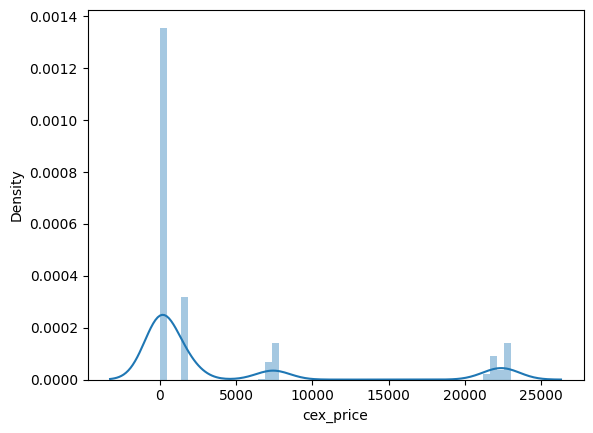

/var/folders/vp/lnx3vw2x7s39s7tbl04ls9780000gn/T/ipykernel_94436/451461628.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical[numerical.columns[i]])


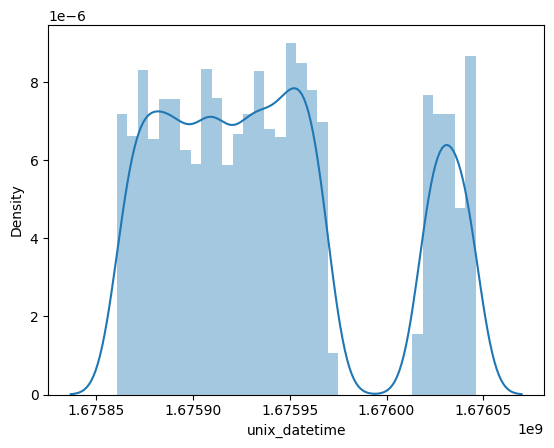

In [12]:
# Exploration (distributions)

for i in range(len(numerical.columns)):
  sns.distplot(numerical[numerical.columns[i]])
  plt.show()

In [13]:
# Se decide no usar transformación(es) o normalización

<AxesSubplot: >

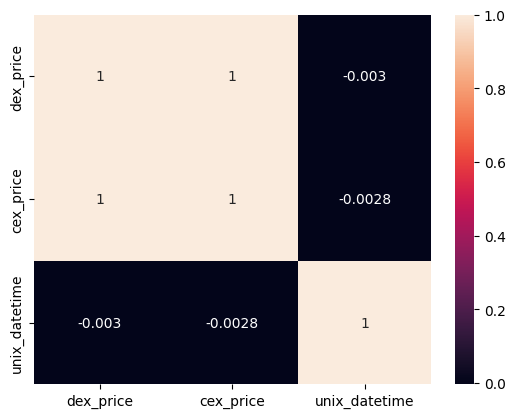

In [14]:
# Correlation exploración

sns.heatmap(numerical.corr(), annot=True)
#numerical.corr()

(array([[14819.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   874.],
        [14410.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  1283.],
        [14820.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   873.],
        [14898.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   795.],
        [15373.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   320.],
        [14303.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  1390.],
        [15074.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   619.],
        [13406.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  2287.],
        [14926.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   767.],
        [14207.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  1486.],
        [1

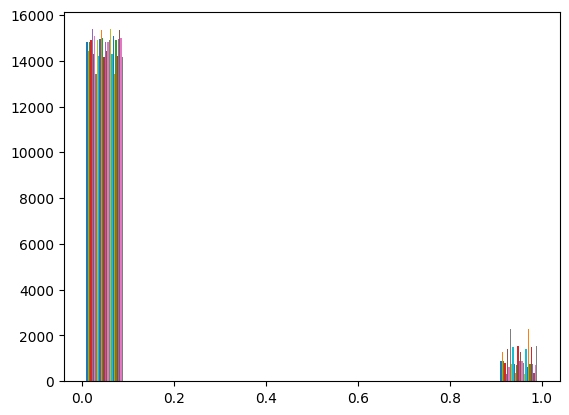

In [15]:
# Encoding Categorical Data.

encoder = OneHotEncoder(drop='first').fit(categorical).transform(categorical).toarray()

#for i in encoder:
#  print(max(i))

plt.hist(encoder)

In [16]:
# Concatenate both tables

encoder_df = pd.DataFrame(encoder)
X=np.concatenate((numerical,encoder_df),axis=1)

# Splitting into train set and test set.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=5)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

#Apply model

# Haciendo el modelo lineal, con una regresión...
lm=linear_model.LinearRegression()

# Entrenar
model=lm.fit(X_train,y_train)


In [17]:
# Concatenate all tables, to export into Tableau
ft = pd.concat([numerical, categorical, time_info, y],axis=1)
ft.to_csv("../data/tableau_data.csv")
    

In [18]:
# Model Validation
predictions=lm.predict(X_test)

# R2
r2s = r2_score(y_test,predictions)
r2s

0.5613743316807669